In [ ]:
#|default_exp peak_pattern_atlas 

# Peak pattern atlas 

> The forest and the trees

Given our ability to generate theoretical XRF spectra we can now build an atlas of spectral peak patterns for different chemical elements. In the following we will ignore the exotic Lanthanides and Actinides and further limit our attention to what I call the *Elements Of Interest*. To plot the periodic table instantiate the `PeriodicTable` class and run the `.plot()` method. The edges of pre-selected elements of interest (to me) are colored red. For interactive plotting we will need to import the holoviews package and activate the `'bokeh'` extension.      

In [ ]:
from moseley import PeriodicTable, PeakPatternAtlas
import holoviews as hv 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
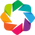

In [ ]:
hv.extension('bokeh')

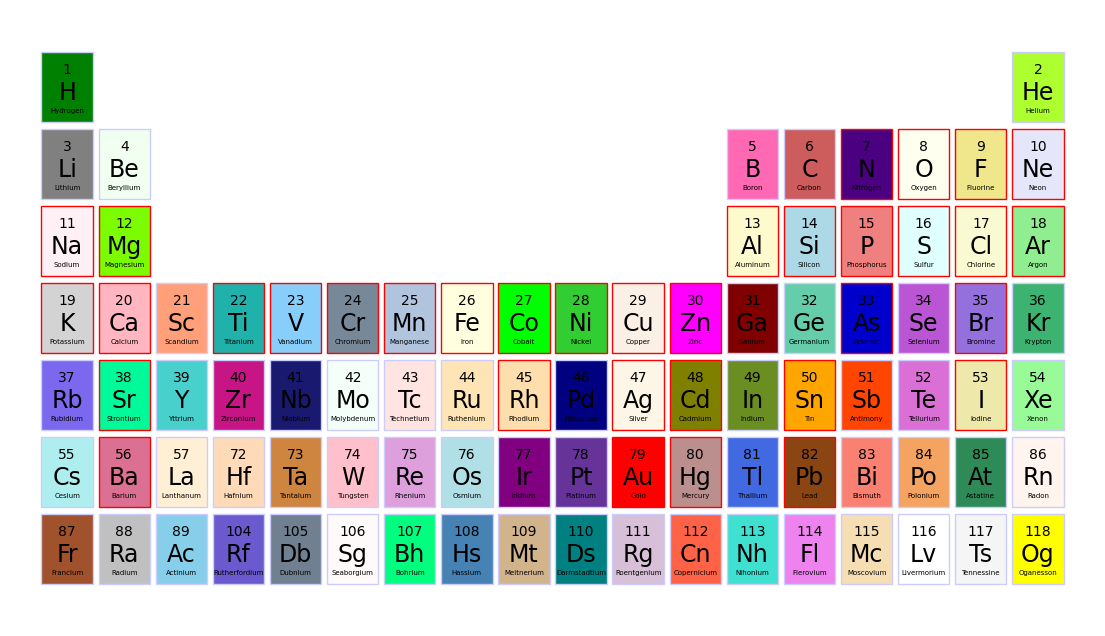

In [ ]:
table = PeriodicTable()
table.plot_table();

We are now in a position to compute our atlas of elemental XRF peak patterns for elements of interest. This will take some 15 seconds. 

In [ ]:
ppa = PeakPatternAtlas()

Ready building Peak Pattern Atlas!                                   


We can now use the `.plot_atlas()` method to create an interactive holoviews plot.  

In [ ]:
atlas = ppa.plot_atlas()
atlas

:Overlay
   .Curve.I      :Curve   [Energy]   (Element)
   .Curve.II     :Curve   [Energy]   (Element)
   .Curve.III    :Curve   [Energy]   (Element)
   .Curve.IV     :Curve   [Energy]   (Element)
   .Curve.V      :Curve   [Energy]   (Element)
   .Curve.VI     :Curve   [Energy]   (Element)
   .Curve.VII    :Curve   [Energy]   (Element)
   .Curve.VIII   :Curve   [Energy]   (Element)
   .Curve.IX     :Curve   [Energy]   (Element)
   .Curve.X      :Curve   [Energy]   (Element)
   .Curve.XI     :Curve   [Energy]   (Element)
   .Curve.XII    :Curve   [Energy]   (Element)
   .Curve.XIII   :Curve   [Energy]   (Element)
   .Curve.XIV    :Curve   [Energy]   (Element)
   .Curve.XV     :Curve   [Energy]   (Element)
   .Curve.XVI    :Curve   [Energy]   (Element)
   .Curve.XVII   :Curve   [Energy]   (Element)
   .Curve.XVIII  :Curve   [Energy]   (Element)
   .Curve.XIX    :Curve   [Energy]   (Element)
   .Curve.XX     :Curve   [Energy]   (Element)
   .Curve.XXI    :Curve   [Energy]   (Element)
   .Curve.XXII   :Curve   [Energy]   (Element)
   .Curve.XXIII  :Curve   [Energy]   (Element)
   .Curve.XXIV   :Curve   [Energy]   (Element)
   .Curve.XXV    :Curve   [Energy]   (Element)
   .Curve.XXVI   :Curve   [Energy]   (Element)
   .Curve.XXVII  :Curve   [Energy]   (Element)
   .Curve.XXVIII :Curve   [Energy]   (Element)
   .Curve.XXIX   :Curve   [Energy]   (Element)
   .Curve.XXX    :Curve   [Energy]   (Element)
   .Curve.XXXI   :Curve   [Energy]   (Element)
   .Curve.XXXII  :Curve   [Energy]   (Element)
   .Curve.XXXIII :Curve   [Energy]   (Element)
   .Curve.XXXIV  :Curve   [Energy]   (Element)
   .Curve.XXXV   :Curve   [Energy]   (Element)
   .Scatter.I    :Scatter   [Energy]   (Element,color,size,name,marker,Line)

## FUNCTIONS 

In [ ]:
#|export 

# Periodic Table 
import mendeleev as mv 
from mendeleev.fetch import fetch_table  

#import moseley as mos 
from moseley import ElementXRF
#from moseley import PeriodicTable

# plotting 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import matplotlib.colors as mcolors 

import holoviews as hv
from holoviews import opts 
from bokeh.models import HoverTool 

import re
import numpy as np


In [ ]:
#|export 

class PeakPatternAtlas():
    '''Create a PeakPatternAtlas instance. '''

    def __init__(self, EOI=None, excitation_energy_keV=25, h_mm=0.001, x_keVs=None, verbose=True, order='alpha'):
        '''Compute an ordered Peak Pattern Atlas for `excitation_energy_keV=25`.'''

        self.table = PeriodicTable(EOI=EOI)

        self.EOI = [element for element in self.table.EOI if not '#'in element]
        
        self.element_xrf_list = [] 
        self.ptrn_dict_list = []

        for i, element in enumerate(self.EOI):     
            if verbose: 
                print(f'Please wait while computing spectral pattern for element {i+1}/{len(self.EOI)}...', end='\r') 

            element_xrf = ElementXRF(element, excitation_energy_keV=excitation_energy_keV, h_mm=h_mm, x_keVs=x_keVs)
            ptrn_dict = element_xrf.ptrn_dict

            self.element_xrf_list.append(element_xrf)
            self.ptrn_dict_list.append(ptrn_dict)

        if order == 'alpha':
            alphas = [ptrn['alpha_keV'] for ptrn in self.ptrn_dict_list]
            idxs = np.argsort(alphas)
            
        elif order == 'Z': 
            atomic_numbers = [ptrn['atomic_number'] for ptrn in self.ptrn_dict_list] 
            idxs = np.argsort(atomic_numbers) 

        self.ptrn_dict_list = [self.ptrn_dict_list[idx] for idx in idxs]  
        self.element_xrf_list = [self.element_xrf_list[idx] for idx in idxs]  
        self.yticks = [(i, xrf.element) for i, xrf in enumerate(self.element_xrf_list)]
            
        if verbose: 
            print('Ready building Peak Pattern Atlas!                                   ') 

    
    def plot_atlas(self, moseley=False): 
        '''Plot holoviews peak pattern atlas from `pattern_dict_list`.''' 
    
        # TODO: add escape and sum peaks 
        # TODO: create separate patterns plotting function for other types of plots 
        
        # STEP 1 
        # create peak pattern dataframe and curve segments 
        # that can be used as plotting data 
    
        ptable = self.table
        colors_dict = ptable.element_colors_dict 
        
        min_size, max_size = 3, 10 
        delta_size = max_size - min_size
        
        df_list = []
        segments_left = []
        segments_right = []
        elements = [] 
        Z_list = []
        
        for i, ptrn_dict in enumerate(self.ptrn_dict_list): 
            
            elem = ptrn_dict['elem'] 
            name = ptrn_dict['name']
            color = colors_dict[elem]
            peaks_x, peaks_y = ptrn_dict['peaks_xy'].T
            peak_labels = ptrn_dict['peak_labels']
            peak_labels = [re.sub('\\d', '', pl) for pl in peak_labels] # strip line number e.g. Ka1 -> Ka 
            atomic_number = ptrn_dict['atomic_number']
            n_rows = len(peaks_x) 
            marker_list = ['circle'] * n_rows 
              
            size = (min_size + delta_size * peaks_y / peaks_y.max()).astype(int) 
                                                
            df = pd.DataFrame(dict(Element=[elem] * n_rows,
                                   Z=atomic_number, 
                                   name=[name] * n_rows, 
                                   Line=peak_labels, 
                                   Energy=peaks_x, 
                                   peaks_y=peaks_y, 
                                   color=[color] * n_rows, 
                                   marker=marker_list, 
                                   size=size)) 
            df_list.append(df) 
    
            segments_left.append(float(peaks_x.min()))
            segments_right.append(float(peaks_x.max()))
            elements.append(elem)
            Z_list.append(atomic_number) 
                              
        ptrns_df = pd.concat(df_list) 
    
        # STEP 2
        # create holoviews Scatter and Curves Overlay elements 
    
        tooltips = [
            ('element', '@name'), 
            ('Line', '@Line'),
            ('Energy (keV)', '@Energy')] 
        
        hover = HoverTool(tooltips=tooltips, attachment='vertical')
    
        energy = hv.Dimension('Energy', unit='keV') 
    
        if moseley: 
            y_dim = 'Z'
        else: 
            y_dim = 'Element' 
    
        scatter = hv.Scatter(ptrns_df, kdims=[energy], vdims=[y_dim, 'color', 'size', 'name', 'marker', 'Line']).opts(color='color', line_color='black', marker='marker', size='size', tools=[hover])
        if moseley: 
            y_values = Z_list
        else: 
            y_values = elements 

        grid_style = {'xgrid_line_color': 'lightgray', 'ygrid_line_color': 'white'} 
        
        curves_list = [hv.Curve(([x0, x1], [y_val, y_val]), kdims=[energy], vdims=y_dim) for x0, x1, y_val in zip(segments_left, segments_right, y_values)]
        curves = hv.Overlay(curves_list).opts(opts.Curve(color='black', line_width=1, gridstyle=grid_style, show_grid=True)) 
    
        atlas = curves * scatter 
        atlas.opts(padding=0.02, frame_width=500, frame_height=500, title='XRF Peak Pattern Atlas')
    
        return atlas 

    

def _fetch_table(): 
    '''Utility function wrapper for mendeleev periodic table data.  
    
    Make dataframe with selected element attributes for regular part of the periodic table.
    The irregular Lanthanides and Actinides series are rare, so we do not plot them. 
    
    Returns: ptable_regular (dataframe) 
    '''
    
    #ptable_df = mv.get_table('elements') # mendeleev 0.5 
    ptable_df = fetch_table('elements')
    ptable = ptable_df[['atomic_number', 'symbol', 'name', 'group_id', 'period']]
    is_regular = ~np.isnan(ptable_df['group_id'].values)

    ptable_regular = ptable[is_regular]
    
    return ptable_regular 


def colorize(ptable_regular): 
    '''Generate regular element colors dictionary. 
    
    Returns: element_colors_dict '''
    
    n_regular = len(ptable_regular) # 90 rows 
    
    # see: https://matplotlib.org/stable/gallery/color/named_colors.html 
    css4_dict = mcolors.CSS4_COLORS 
        
    # hack to select brightest colors and exclude american double grays 
    css4_names = list(css4_dict.keys()) 
    css4_names = sorted(sorted(css4_names, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))) # brightest colors 
    css4_names = [name for name in css4_names if 'gray' not in name] # exclude doubles grays 

    # pick brightest 90 
    n_names = len(css4_names) 
    css4_names = css4_names[n_names - n_regular - 1:n_names - 1]

    element_colors_dict = dict(zip(ptable_regular['symbol'], css4_names))

    return element_colors_dict


def _draw_box(ax, element_attrs, edgecolor=None, facecolor=None):
    '''Draw a box for element *element_attrs*  in subplot *ax*. '''
    
    w = 0.9
    h = 0.9
    
    atomic_number, symbol, name, x, y = element_attrs 
    
    if edgecolor is None: 
        edgecolor = [0.8, 0.8, 1.0]
        
    if facecolor is None: 
        facecolor = [0.95, 0.95, 1.0]
    
    rect = mpatches.Rectangle([x - w/2, y - h/2], h, w, edgecolor=edgecolor, facecolor=facecolor)
    ax.add_patch(rect)
    
    ax.annotate(symbol, [x, y], xytext=[0, -4], textcoords='offset points',
                va='center', ha='center', fontsize=17)
    
    ax.annotate(atomic_number, [x, y], xytext=[0, 12], textcoords='offset points', 
                va='center', ha='center', fontsize=10)
    
    ax.annotate(name, [x, y], xytext=[0, -17], textcoords='offset points',
                va='center', ha='center', fontsize=5)


def _sort_ptrn_list(ptrn_dict_list, order='alpha'): 
    '''Utility function to sort ptrn_dict_list in 'alpha' or 'Z' order. 
    
    Returns: sorted_ptrn_list '''

    if order == 'alpha': 
        alpha_list = [ptrn['alpha_keV'] for ptrn in ptrn_dict_list]
        idxs = np.argsort(alpha_list)
    elif order == 'Z': 
        Z_list = [ptrn['atomic_number'] for ptrn in ptrn_dict_list] 
        idxs = np.argsort(Z_list)
        
    sorted_ptrn_list = [ptrn_dict_list[i] for i in idxs]  
        
    return sorted_ptrn_list


class PeriodicTable(): 
    '''Create a periodic table of elements. '''
    
    
    def __init__(self, EOI=None): 

        if EOI is None: 
            self.EOI = ['#H', '#He', '#Li', '#Be', '#B', '#C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 
                        'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', '#Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 
                        'Co', 'Ni', 'Cu', 'Zn', '#Ga', '#Ge', 'As', '#Se', 'Br', '#Kr', '#Rb', 'Sr', 
                        '#Y', '#Zr', '#Nb', '#Mo', '#Tc', '#Ru', 'Rh', '#Pd', 'Ag', 'Cd', '#In', 'Sn', 
                        '#Sb', '#Te', 'I', '#Xe', '#Cs', 'Ba', '#La', '#Hf', '#Ta', '#W', '#Re', '#Os', 
                        '#Ir', '#Pt', 'Au', 'Hg', '#Tl', 'Pb', '#Bi', '#Po', '#At', '#Rn', '#Fr', '#Ra', 
                        '#Ac', '#Rf', '#Db', '#Sg', '#Bh', '#Hs', '#Mt', '#Ds', '#Rg', '#Cn', '#Nh', 
                        '#Fl', '#Mc', '#Lv', '#Ts', '#Og']    
        else: 
            self.EOI = EOI 
     
    
        # fetch regular part of periodic table 
        self.ptable_regular = _fetch_table() 
    
        # generate element colors dict 
        self.element_colors_dict = colorize(self.ptable_regular) 


    def plot_table(self, ax=None, figname=None): 
        '''Create periodic table plot with selected elements colorized.'''
    
        if ax is None: 
            fig, ax = plt.subplots(figsize=[14, 8])
        else: 
            fig = ax.get_figure()
            
        ax.invert_yaxis()
    
        for i, element_attrs in enumerate(self.ptable_regular.values): 
    
            atomic_number, symbol, name, x, y = element_attrs 
            facecolor = self.element_colors_dict[symbol] 
            
            if symbol in self.EOI: 
                edgecolor = 'r' 
            else: 
                edgecolor = None
            _draw_box(ax, element_attrs, edgecolor=edgecolor, facecolor=facecolor)
    
        ax.set_xlim(0, 19)
        ax.set_ylim(8, 0)
        ax.axis('off');
        
        if figname is not None: 
    
            fig.savefig(figname)
    
        return ax